In [1]:
import torch
from torch import nn
import numpy as np
import pylab as pl
from IPython.display import clear_output

In [2]:
from sklearn.datasets import load_digits, load_iris
dataset = load_digits()
data = dataset.data
label = dataset.target
n_samples, n_features = data.shape

data[np.random.rand(n_samples, n_features) < 0.1] *= 10
data[np.random.rand(n_samples, n_features) < 0.01] *= 100

In [3]:
data = np.stack((data, np.log(data + 1)), -1)

data = (data - np.mean(data, axis=0)) / (np.std(data, axis=0) + 1e-8) 

In [158]:
class BatchNormedMLP(nn.Module):
    def __init__(self, in_features, out_features, activation=nn.ReLU()):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features, out_features),
            activation,
            nn.BatchNorm1d(out_features)
        )

    def forward(self, x):
        return self.layers(x)

class SkipMLP(nn.Module):
    def __init__(self, input_dimension, n_layers=1, activation=nn.ReLU()):
        super().__init__()
        self.layers = nn.Sequential(*[BatchNormedMLP(input_dimension, input_dimension, activation) for _ in range(n_layers)])

    def forward(self, x):
        return x + self.layers(x)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.input_layer = BatchNormedMLP(input_dim, hidden_dim)
        self.hidden_layers = nn.Sequential(*[SkipMLP(hidden_dim, 1) for _ in range(3)])
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layers(x)
        return self.output_layer(x)

model = MLP(128, 512, 10)

In [155]:
min(test_losses), test_losses[-1]

(0.48798030614852905, 0.7431979775428772)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
for epoch in range(1000):
    optimizer.zero_grad()
    output = model(X_train.reshape(-1, 128))
    train_loss = criterion(output, y_train)
    train_loss.backward()
    optimizer.step()

    with torch.no_grad():
        output = model(X_test.reshape(-1, 128))
        test_loss = criterion(output, y_test)

    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())

    if epoch % 10 == 0:
        clear_output(True)
        pl.semilogy(train_losses, label='train loss')
        pl.semilogy(test_losses, label='test loss')
        pl.legend()
        pl.show()

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    torch.from_numpy(data).float(), torch.from_numpy(label).long(), test_size=0.2, random_state=42)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
clf = RandomForestClassifier(500).fit(X_train.reshape(-1, 128), y_train)

log_loss(y_test, clf.predict_proba(X_test.reshape(-1, 128)))

0.3125787108678087

In [30]:
class MySelfAttention(nn.Module):
    def __init__(self, embedding_dim, d_k, d_v):
        super().__init__()
        self.d_k = d_k
        self.W_q = nn.Linear(embedding_dim, d_k)
        self.W_k = nn.Linear(embedding_dim, d_k)
        self.W_v = nn.Linear(embedding_dim, d_v)
        self.activation = nn.Softmax(dim=-1)

    def forward(self, x):
        attention_mask = self.get_attention_mask(x) # b l l
        v = self.W_v(x) # b l v
        return torch.einsum("bij, bjv -> biv", attention_mask, v) # b l v

    def get_attention_mask(self, x):
        q = self.W_q(x) # b l k
        k = self.W_k(x) # b l k
        return self.activation(torch.einsum("bik, bjk -> bij", q, k) / np.sqrt(self.d_k)) # b l l

def get_sinusoidal_embeddings(embedding_dim, n_samples):
        samples = torch.arange(n_samples).reshape(-1, 1)
        w = torch.arange(1, embedding_dim + 1) / n_samples * np.pi
        return torch.sin(w * samples)

class MyTransformer(nn.Module):
    def __init__(self, embedding_dim, kernel_dim, output_dim, n_features):
        super().__init__()

        self.kernel_dim = kernel_dim
        self.n_features = n_features
        self.positional_embeddings_dim = 16
        self.pos_embeddings = nn.Embedding(self.n_features, self.positional_embeddings_dim)
        self.attention = MySelfAttention(embedding_dim + self.positional_embeddings_dim, kernel_dim, kernel_dim)
        self.relu = nn.ReLU()

        self.output = nn.Linear(n_features, output_dim)

    def forward(self, x):
        pos_embeddings = self.pos_embeddings(torch.arange(self.n_features)).unsqueeze(0).repeat(x.shape[0], 1, 1)
        x = torch.cat((x, pos_embeddings), -1)
        attn = self.attention(x) # b l v

        return self.output(self.relu(attn.mean(dim=2)))

model = MyTransformer(2, 64, 10, 64)

In [57]:
def plot_attention_mask():
    with torch.no_grad():
        x = X_train
        pos_embeddings = model.pos_embeddings(torch.arange(model.n_features)).unsqueeze(0).repeat(x.shape[0], 1, 1)
        x = torch.cat((x, pos_embeddings), -1)
        attention_mask = np.abs(model.attention.get_attention_mask(x).detach().numpy())

        pl.matshow(attention_mask.mean(0))
        pl.matshow(attention_mask.mean(0).mean(1).reshape(8,8))
        pl.show()

def cosine_similarity(x):
    x_norm =  x.norm(dim=-1) + 1e-8
    return torch.einsum('ie, je -> ij', [x, x]) / x_norm / x_norm.reshape(-1, 1)

def plot_pos_embeddings():
    with torch.no_grad():
        pos_embeddings = model.pos_embeddings(torch.arange(model.n_features))
        pl.plot(pos_embeddings[:, 0:2])
        pl.show()

In [87]:
class Transformer(nn.Module):
    def __init__(self, embedding_dim, kernel_dim, positional_embeddings_dim, output_dim, n_features):
        super().__init__()
        self.n_features = n_features

        self.pos_embeddings = nn.Embedding(self.n_features, positional_embeddings_dim)
        self.encoder = nn.Linear(embedding_dim, kernel_dim-positional_embeddings_dim)
        attention_layer = nn.TransformerEncoderLayer(kernel_dim, 1, 16, batch_first=True)
        self.layers = nn.TransformerEncoder(attention_layer, 3)
        self.relu = nn.ReLU()
        self.output = nn.Linear(kernel_dim, output_dim)

        self.device = 'cpu'

    def forward(self, x):
        x = x.to(self.device)
        pos_embeddings = self.pos_embeddings(torch.arange(self.n_features)).unsqueeze(0).repeat(x.shape[0], 1, 1)
        x = torch.cat((self.encoder(x), pos_embeddings), -1)
        attn = self.layers(x) # b l v

        return self.output(attn.mean(dim=1))
        
model = Transformer(2, 64, 8, 10, 64)

In [89]:
min(test_losses), test_losses[-1]

(0.23862844705581665, 0.30502331256866455)

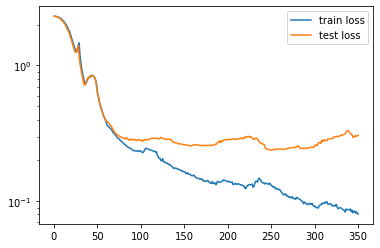

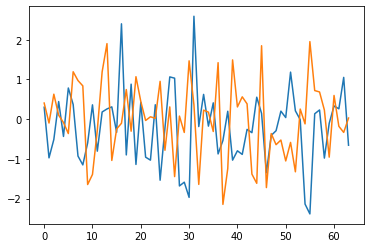

KeyboardInterrupt: 

In [88]:
# Optimize the model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    train_loss = criterion(output, y_train)
    train_loss.backward()
    optimizer.step()

    with torch.no_grad():
        model.eval()
        output = model(X_test)
        test_loss = criterion(output, y_test)

    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())

    if epoch % 10 == 0:
        clear_output(True)
        pl.semilogy(train_losses, label='train loss')
        pl.semilogy(test_losses, label='test loss')
        pl.legend()
        pl.show()

        #plot_attention_mask()
        plot_pos_embeddings()
    